## Last Updated 2024-08-03
## Maxwell A. Fine 

### Goals:
* Make plots of SNR, Fluence, $E_{\nu}$ for the crab over many hours of observations
* Compare to 2019, 2024 Crab paper, and Jason Hessels Paper
* Addtionaly make some stastical plots of the Crab in the different Bands



### TODO:
* [] Add line for known DM of Crab
* [] Add fancy telephone number for crab 
* [] Add Power Laws from papers, and add hyperlinks to papers
* [ ] Fit both a broken, and simple power law to our data
* [] Force rebinning, so Poission error holds
* [ ] Convert SNR to Fluence, and $E_{\nu}$
        - For Fluence, would need burst width - maybe I can integrate in SNR and then convert
        - Are the `.h5` files good enough - they were made for fetch so 250x250? or do I need to make higher qualilty ones?


### Assumptions:
* SNR ~ Fluence ~ $E_{\nu}$
    - SNR ~ Fluence, works if the width of the burst does not depend on its brightness 
    - Not sure about $E_{\nu}$



Important commands to make a txt file of all the good .h5 files:

```bash
find . -type d -name 'good' -exec find {} -type f -name 'CRAB*.h5' \; > /data/frb/crab_goodh5_candidates.txt
```

This one copies that file to your cwd (magic jupyter):
```bash
!scp uranus:/data/frb/crab_goodh5_candidates.txt .
```

In [1]:
pwd

'/home/afinemax/afinemax/khazad-dum/research/astron_2024/crab_analysis'

In [2]:
!scp uranus:/data/frb/crab_goodh5_candidates.txt .

crab_goodh5_candidates.txt                    100%  863KB   3.6MB/s   00:00    


### Imports & Global Variables

In [99]:
import numpy as np 
import matplotlib.pyplot as plt     
import pandas as pd 
import os.path
from datetime import datetime, timedelta

freq_ranges = {
    "L1": (1200,1300),
    "L2": (1300,1400),
    "PH": (400,420),
    "PV": (400,420),
} # in Mhz

# Band colors
band_colors = {'L1': '#D81B60', 'L2': '#1E88E5','PH': '#FFC107', 'PV': '#004D40'} 



In [87]:
# Read in and make a pandas df from the .txt file
data = []
with open("crab_goodh5_candidates.txt", "r") as f:
    for line in f:
        parts = os.path.basename(line.strip()).split("_")
        band = parts[1]
        fil_time_str = "-".join(parts[3:6]) + "T" + ":".join(parts[6:9])
        fil_time = datetime.fromisoformat(fil_time_str)
        candidate_time = fil_time + timedelta(seconds=float(parts[10]))
        dm = float(parts[12])
        snr = float(parts[14][:-4])
        data.append([band, candidate_time, dm, snr])
df = pd.DataFrame(data, columns=["band", "candidate_time", "dm", "snr"])

# Display the first 3 rows
print(df.head(3))

  band             candidate_time    dm    snr
0   PH 2024-07-22 16:11:28.897536  56.9   10.0
1   L2 2024-07-22 14:18:48.680211  56.4  163.0
2   PH 2024-07-22 15:34:33.040640  56.9   15.0


### DM of observations 

In [120]:
def plot_dm_histogram(df, band_colors, save_path='crab_dm.png'):
    """
    Plots histograms of DM values from the DataFrame and saves the plot to a file.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing 'band', 'candidate_time', 'dm', 'snr' columns.
    - band_colors (dict): Dictionary mapping bands to colors. 
    - save_path (str): Path where the plot image will be saved. Default is 'crab_dm.png'.
    """
    # Set the size of the figure (width, height) in inches
    fig_size = (10, 6)  

    # Set up the figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Set overall title for the entire figure
    plt.suptitle('Measured DM of Crab', size=15)

    # Get unique bands and initialize the color dictionary
    bands = df['band'].unique()

    # Plot histogram for the total dataset
    total_dm_values = df['dm']
    total_n = len(total_dm_values)
    total_num_bins = int(np.sqrt(total_n))  # Square root of number of data points
    ax.hist(total_dm_values, bins=total_num_bins, color='black', edgecolor='black', alpha=0.5, 
            density=True, label=f'Total, N = {total_n}')

    # Plot histogram for each band
    for i, band in enumerate(bands):
        band_data = df[df['band'] == band]
        dm_values = band_data['dm']
        
        # Calculate number of bins
        num_bins = int(np.sqrt(len(dm_values)))  # Square root of number of data points

        # Plot histogram with normalization
        ax.hist(dm_values, bins=num_bins, color=band_colors.get(band, 'gray'), edgecolor='black', alpha=0.5, 
                density=True, label=f'{band}, N = {len(dm_values)}')

    # Add a vertical dashed line for the true DM value of the Crab Pulsar
    true_dm = 56.8  # True DM value for the Crab Pulsar in pc/cm^3
    ax.axvline(x=true_dm, color='k', linestyle='--', linewidth= 3, label=f'True DM = {true_dm} pc/cm^3',)

    # Labeling and legend
    ax.set_xlabel('DM (pc/cm^3)', size=15)
    ax.set_ylabel('Probability', size=15)
    ax.legend(title='Bands', title_fontsize='13', fontsize='12')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust to fit suptitle and legend

    # Save the plot to a file
    plt.savefig(save_path)

    # Display the plot
    plt.show()


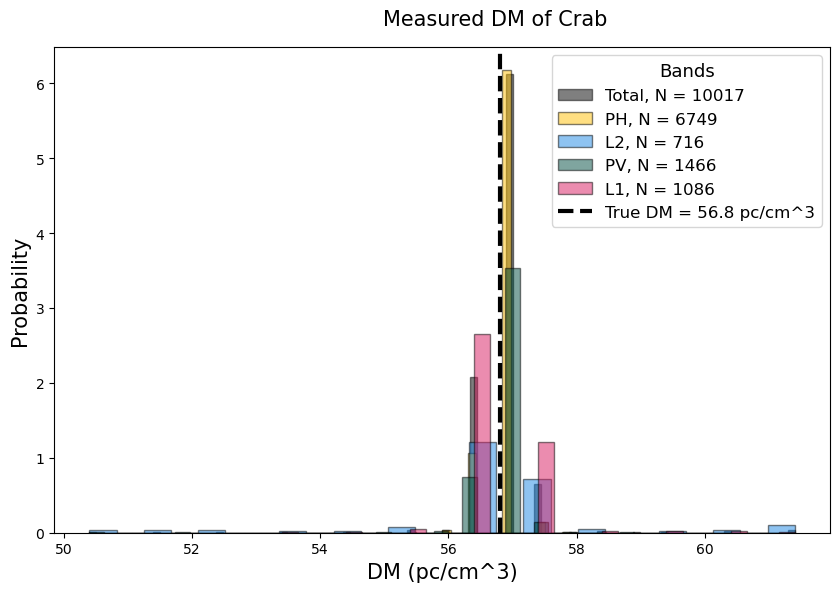

In [121]:
plot_dm_histogram(df, band_colors, )

### SNR plot

In [112]:
def plot_snr_histogram(df, band_colors, save_path='snr_freq.png'):
    """
    Plot histogram of SNR values for different bands and save the plot if required.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'band' and 'snr' columns.
    band_colors (dict,): Dictionary mapping bands to colors. 
    save_path (str, optional): Path to save the plot image. If None, the plot is not saved. Defaults to None.
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bands = df['band'].unique() 
    total_snr = np.concatenate([df[df['band'] == band]['snr'].values for band in bands])
    N_total = len(total_snr)
    bins_total = int(np.sqrt(0.5 * N_total)) if N_total > 1 else 1  # Ensure at least 1 bin

    # Compute total histogram
    total_counts, total_bin_edges = np.histogram(total_snr, bins=bins_total)
    total_bin_centers = (total_bin_edges[:-1] + total_bin_edges[1:]) / 2

    # Calculate sample size per bin for total histogram
    total_bin_width = total_bin_edges[1] - total_bin_edges[0]
    total_sample_counts_per_bin = np.array([np.sum((total_snr >= total_bin_edges[i]) & (total_snr < total_bin_edges[i+1])) for i in range(len(total_bin_edges) - 1)])
    total_errors = total_counts / np.sqrt(total_sample_counts_per_bin)

    # Plot total histogram in black
    ax.errorbar(total_bin_centers, total_counts, yerr=total_errors, fmt='o', color='black', alpha=0.7, label=f'Total (N = {N_total})')

    # Plot each band's histogram
    for band in bands:
        band_data = df[df['band'] == band]
        N = 0.5 * len(band_data)  # Number of samples in the current band
        bins = int(np.sqrt(N)) if N > 1 else 1  # Ensure at least 1 bin
        
        counts, bin_edges = np.histogram(band_data['snr'], bins=bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Calculate sample size per bin
        bin_width = bin_edges[1] - bin_edges[0]
        sample_counts_per_bin = np.array([np.sum((band_data['snr'] >= bin_edges[i]) & (band_data['snr'] < bin_edges[i+1])) for i in range(len(bin_edges) - 1)])
        # Calculate errors
        errors = counts / np.sqrt(sample_counts_per_bin)
        # Plot scatter points with error bars
        ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', color=band_colors.get(band, 'gray') if band_colors else 'gray', alpha=0.6, label=f'Crab {band} (N = {N})')

    # Add labels and legend
    ax.set_title('SNR vs freq', size=15)
    ax.set_xlabel('SNR', size=15)
    ax.set_ylabel('Count', size=15)
    ax.set_yscale('log')  # Set y-axis to log scale
    ax.legend(title='Band')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)

    plt.show()




/tmp/ipykernel_31472/3177013228.py:25: RuntimeWarning: invalid value encountered in divide
  total_errors = total_counts / np.sqrt(total_sample_counts_per_bin)
/tmp/ipykernel_31472/3177013228.py:43: RuntimeWarning: invalid value encountered in divide
  errors = counts / np.sqrt(sample_counts_per_bin)
/tmp/ipykernel_31472/3177013228.py:43: RuntimeWarning: divide by zero encountered in divide
  errors = counts / np.sqrt(sample_counts_per_bin)


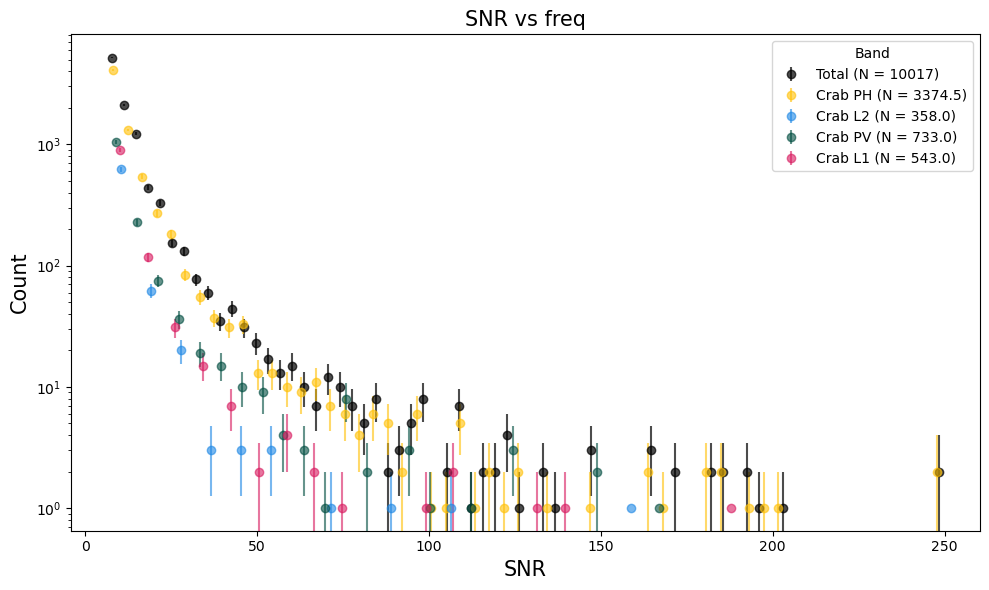

In [113]:
plot_snr_histogram(df, band_colors=band_colors, save_path='snr_freq.png')
